Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


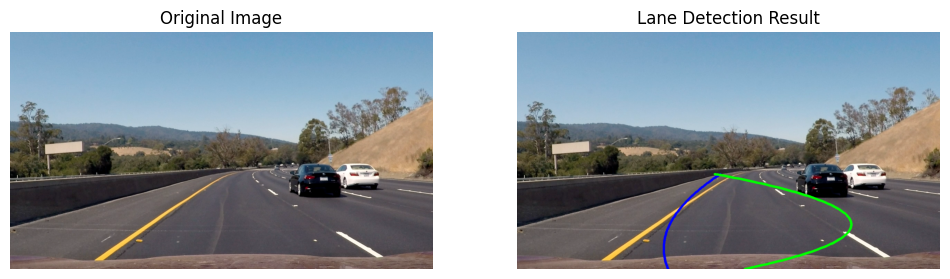

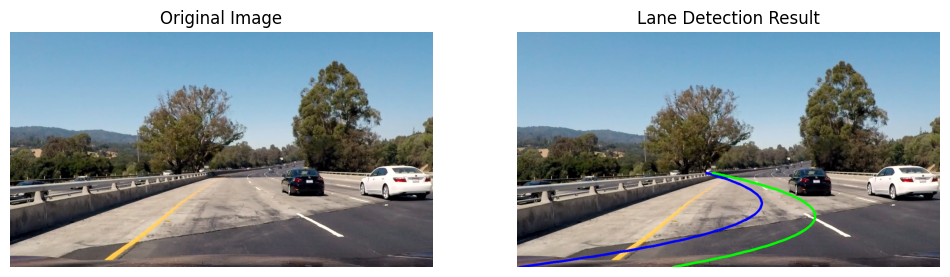

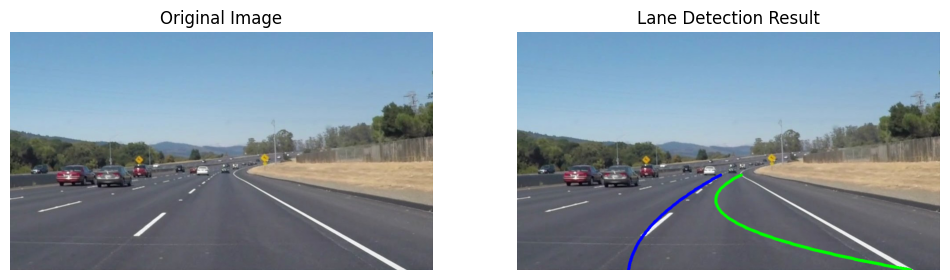

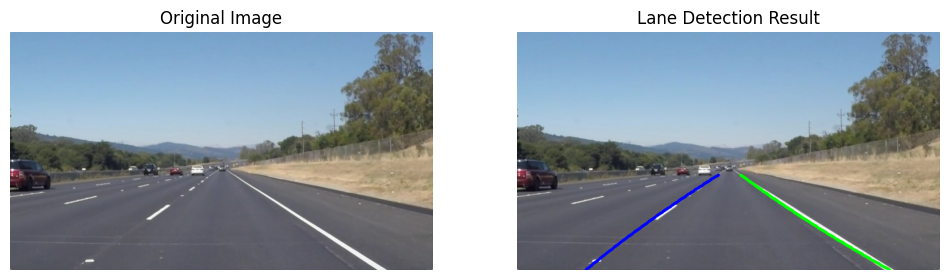

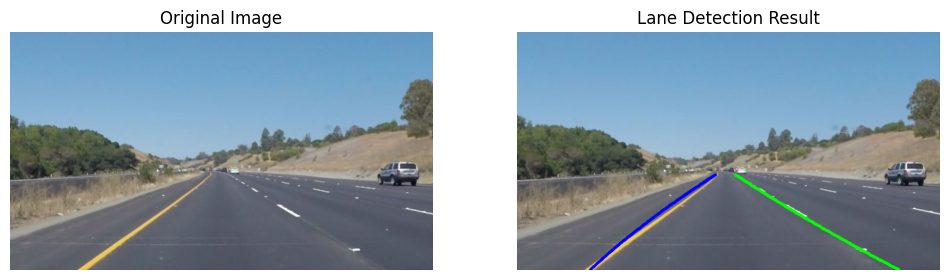

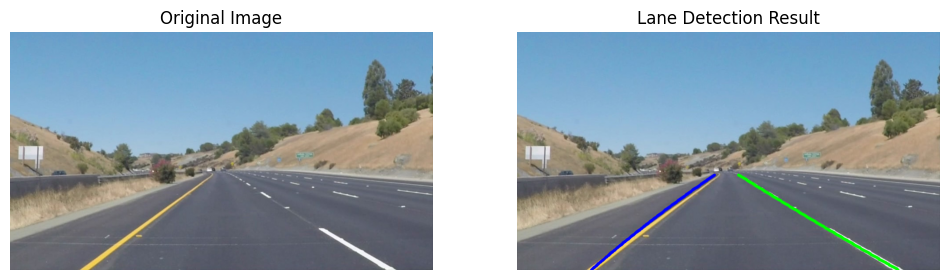

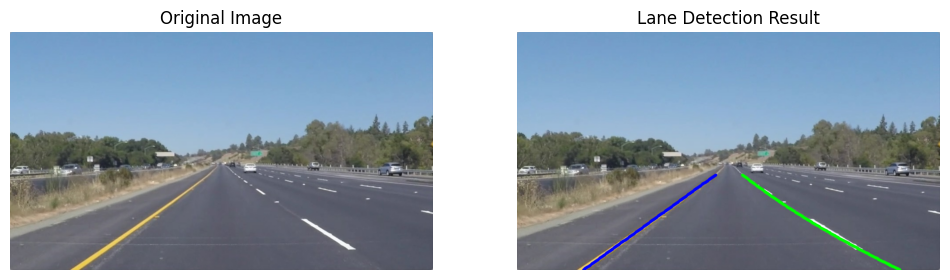

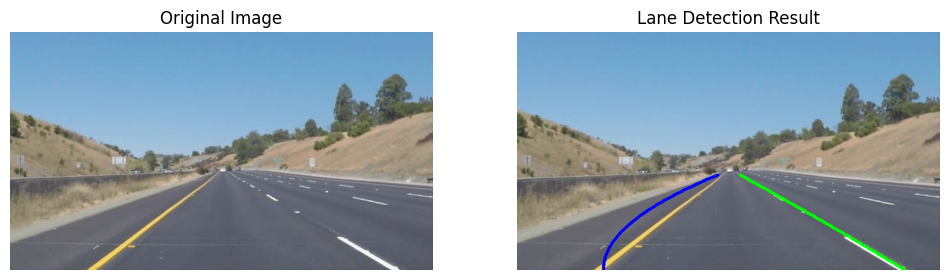

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

input_dir = '/content/drive/My Drive/CS543/Project/test_images'

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[
        (0, height),
        (width, height),
        (int(width * 0.6), int(height * 0.6)),
        (int(width * 0.4), int(height * 0.6))
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(edges, mask)

def detect_hough_lines(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, minLineLength=30, maxLineGap=200)
    return lines

def separate_lines(lines, image):
    height, width, _ = image.shape
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)
        if slope < 0:
            left_lines.append(line)
        elif slope > 0:
            right_lines.append(line)
    return left_lines, right_lines

def fit_curve_smooth(lines, height):
    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]
    if len(x_coords) < 2:
        return None
    poly_fit = np.polyfit(y_coords, x_coords, 2)
    return poly_fit

def draw_lane_lines(image, poly_fit, color, y_min, y_max):
    if poly_fit is None:
        return
    y_coords = np.linspace(y_min, y_max, num=100)
    x_coords = np.polyval(poly_fit, y_coords)
    points = np.array([(int(x), int(y)) for x, y in zip(x_coords, y_coords) if 0 <= x < image.shape[1]], dtype=np.int32)
    if len(points) > 1:
        cv2.polylines(image, [points], isClosed=False, color=color, thickness=5)

def process_image(image):
    edges = preprocess_image(image)
    roi_edges = region_of_interest(edges)
    lines = detect_hough_lines(roi_edges)

    if lines is not None:
        left_lines, right_lines = separate_lines(lines, image)
        height = image.shape[0]
        left_curve = fit_curve_smooth(left_lines, height)
        right_curve = fit_curve_smooth(right_lines, height)
        result = image.copy()
        draw_lane_lines(result, left_curve, color=(255, 0, 0), y_min=int(height * 0.6), y_max=height)
        draw_lane_lines(result, right_curve, color=(0, 255, 0), y_min=int(height * 0.6), y_max=height)
    else:
        result = image.copy()

    return result

image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg') or f.endswith('.png')]

for filename in image_files:
    input_path = os.path.join(input_dir, filename)
    image = cv2.imread(input_path)
    if image is None:
        continue
    result = process_image(image)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Lane Detection Result")
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges

def region_of_interest(edges):
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[
        (0, height),
        (width, height),
        (int(width * 0.6), int(height * 0.6)),
        (int(width * 0.4), int(height * 0.6))
    ]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(edges, mask)

def detect_hough_lines(edges):
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, minLineLength=30, maxLineGap=200)
    return lines

def separate_lines(lines, image):
    height, width, _ = image.shape
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)
        if slope < 0:
            left_lines.append(line)
        elif slope > 0:
            right_lines.append(line)
    return left_lines, right_lines

def fit_curve_smooth(lines, height):
    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]
    if len(x_coords) < 2:
        return None
    poly_fit = np.polyfit(y_coords, x_coords, 2)
    return poly_fit

def draw_lane_lines(image, poly_fit, color, y_min, y_max):
    if poly_fit is None:
        return
    y_coords = np.linspace(y_min, y_max, num=100)
    x_coords = np.polyval(poly_fit, y_coords)
    points = np.array([(int(x), int(y)) for x, y in zip(x_coords, y_coords) if 0 <= x < image.shape[1]], dtype=np.int32)
    if len(points) > 1:
        cv2.polylines(image, [points], isClosed=False, color=color, thickness=5)

def process_image(image):
    edges = preprocess_image(image)
    roi_edges = region_of_interest(edges)
    lines = detect_hough_lines(roi_edges)

    if lines is not None:
        left_lines, right_lines = separate_lines(lines, image)
        height = image.shape[0]
        left_curve = fit_curve_smooth(left_lines, height)
        right_curve = fit_curve_smooth(right_lines, height)
        result = image.copy()
        draw_lane_lines(result, left_curve, color=(255, 0, 0), y_min=int(height * 0.6), y_max=height)
        draw_lane_lines(result, right_curve, color=(0, 255, 0), y_min=int(height * 0.6), y_max=height)
    else:
        result = image.copy()

    return result

input_video_path = '/content/drive/My Drive/CS543/Project/Drive_01.mp4'
output_video_path = '/content/drive/My Drive/CS543/Project/paper_output.mp4'

cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    processed_frame = process_image(frame)
    out.write(processed_frame)

cap.release()
out.release()
